In [2]:
import numpy as np
import pandas as pd

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from datetime import datetime

import pyproj


import descartes
%matplotlib inline
import matplotlib.pyplot as plt

import shapely
import contextily as cx

import open_cp.data
import open_cp.geometry
import open_cp.plot
import matplotlib.collections
import open_cp.kernels

import sepp.sepp_grid
import datetime

In [3]:
#Intervention: 

#Consider one grid
#for each crime in that grid must calculate the prediction value for that crime in the grid point on the day of the crime 
#with each crime store that value in a dataframe 


#we need a function that takes in a date and a set of coordinates and returns the probability that predpol would return if you 
#trained it on everything prior!

In [37]:
#get the crime data from here https://data.lacity.org/Public-Safety/Crime-Data-from-2010-to-2019/63jg-8b9z
#crime = pd.read_csv('Crime_Data_from_2010_to_2019.csv')
#crime['DATE OCC'] = crime['DATE OCC'].apply(lambda x: datetime.strptime(x,  '%m/%d/%Y %H:%M:%S %p'))

crime = pd.read_csv('2018LAcrime.csv')
crime['DATE OCC'] = crime['DATE OCC'].apply(lambda x: datetime.datetime.strptime(x,  '%Y-%m-%d %H:%M:%S'))

crime = crime[crime['DATE OCC'].dt.year == 2018]
crime = crime[~((crime.LAT==0)&(crime.LON==0))]

timestamps = crime['DATE OCC']

#project
#proj = pyproj.Proj({"init":"EPSG:2229"})
#xcoords, ycoords = proj(crime['LON'].values, crime['LAT'].values)
xcoords, ycoords = crime.LON, crime.LAT

#combine time and spatial
points = open_cp.data.TimedPoints.from_coords(timestamps, xcoords, ycoords)
print(points.number_data_points)
print(points.time_range)

#la map
frame = gpd.read_file('/Users/annieulichney/Desktop/PredPolAnnie/County_Boundary.geojson')
geo = list(frame.geometry)[3]

#projected version
frame_proj = frame.to_crs(epsg=3857)
geo_proj = list(frame_proj.geometry)[3]

#project the coordinates
proj = pyproj.Proj({"init":"EPSG:3857"})
xcoords_proj, ycoords_proj = proj(crime['LON'].values, crime['LAT'].values)

#make grid on projected version

grid_proj = open_cp.data.Grid(xsize=1000, ysize=1000, xoffset=0, yoffset=0)
grid_proj = open_cp.geometry.mask_grid_by_intersection(geo_proj, grid_proj)

store_grid_proj = open_cp.plot.lines_from_grid(grid_proj)


points_proj = open_cp.data.TimedPoints.from_coords(timestamps, xcoords_proj, ycoords_proj)


154430
(numpy.datetime64('2018-01-01T12:00:00.000'), numpy.datetime64('2018-12-31T12:00:00.000'))


/Users/annieulichney/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [38]:
pred_vec = []
start_index = round(crime.shape[0]/3)

for i in range(start_index, crime.shape[0]):
    crime.iloc[i]
    this_lat = crime.iloc[i].LAT
    this_lon = crime.iloc[i].LON

    this_date = crime.iloc[i]['DATE OCC']

    #train the data
    trainer = sepp.sepp_grid.ExpDecayTrainer(grid_proj)
    trainer.data = points_proj

    #model = trainer.train(datetime.datetime(2019,12,1))

    model = trainer.train(this_date)
    pred = trainer.prediction_from_background(model)

    grid_x, grid_y = grid_proj.grid_coord(xcoords_proj[i], ycoords_proj[i])

    prediction_at_crime = pred.intensity_matrix[grid_y][grid_x]

    pred_vec.append(prediction_at_crime)

    #print('Trained and calculated prediction for crime ' + str(i) + ' at ' + str(this_lat) + ', ' + str(this_lon) + ' : ' + str(prediction_at_crime))


/Users/annieulichney/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/annieulichney/Desktop/PredPolAnnie/sepp/sepp_grid.py:370: RuntimeWarning: divide by zero encountered in double_scalars
  return over / under
/Users/annieulichney/Desktop/PredPolAnnie/sepp/sepp_grid.py:445: RuntimeWarning: invalid value encountered in multiply
  return _np.exp(- self._omega * tdelta) * self._omega * self._theta


KeyboardInterrupt: 

In [ ]:
crime = crime.iloc[start_index:crime.shape[0]]

crime['prior_pred'] = pred_vec

,Unnamed: 0,Unnamed: 0.1,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
51477,51477,1723990,181907843,03/15/2018 12:00:00 AM,2018-03-15 12:00:00,1630,19,Mission,1903,2,...,IC,Invest Cont,930.0,NaN,NaN,NaN,14400 OLIVE VIEW DR,NaN,34.3271,-118.4498
51478,51478,1723991,182018715,10/12/2018 12:00:00 AM,2018-10-11 12:00:00,2100,20,Olympic,2022,1,...,IC,Invest Cont,330.0,NaN,NaN,NaN,3900 WILSHIRE BL,NaN,34.0655,-118.3114
51479,51479,1723992,181509731,04/18/2018 12:00:00 AM,2018-04-18 12:00:00,1940,15,N Hollywood,1527,1,...,IC,Invest Cont,510.0,NaN,NaN,NaN,VICTORY,BAKMAN,34.1867,-118.3779
51480,51480,1723993,181817097,08/16/2018 12:00:00 AM,2018-08-16 12:00:00,200,18,Southeast,1836,2,...,AO,Adult Other,624.0,NaN,NaN,NaN,1500 E 106TH ST,NaN,33.9397,-118.2483
51481,51481,1723994,180513038,07/09/2018 12:00:00 AM,2018-07-06 12:00:00,1940,5,Harbor,505,2,...,IC,Invest Cont,740.0,NaN,NaN,NaN,1200 W 190TH ST,NaN,33.8583,-118.2971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154428,154428,1826941,180415313,09/25/2018 12:00:00 AM,2018-09-25 12:00:00,30,4,Hollenbeck,439,2,...,IC,Invest Cont,740.0,NaN,NaN,NaN,5000 VALLEY BL,NaN,34.0694,-118.1754
154429,154429,1826942,180409839,05/15/2018 12:00:00 AM,2018-05-14 12:00:00,2300,4,Hollenbeck,427,1,...,IC,Invest Cont,330.0,NaN,NaN,NaN,BOWMAN BL,GAMBIER ST,34.0810,-118.1825
154430,154430,1826943,181708130,03/26/2018 12:00:00 AM,2018-03-01 12:00:00,1200,17,Devonshire,1781,2,...,IC,Invest Cont,354.0,NaN,NaN,NaN,8700 DE SOTO AV,NaN,34.2282,-118.5885
154431,154431,1826944,182120873,12/20/2018 12:00:00 AM,2018-12-20 12:00:00,2245,21,Topanga,2114,2,...,IC,Invest Cont,624.0,NaN,NaN,NaN,22300 STRATHERN ST,NaN,34.2156,-118.6123


In [35]:
pred_vec

[0.09589041122246092,
 0.5057520440765524,
 0.2337364086512817,
 0.5188670361615593,
 0.043010752688172046]

In [25]:
#train the data
trainer = sepp.sepp_grid.ExpDecayTrainer(grid_proj)
trainer.data = points_proj

#model = trainer.train(datetime.datetime(2019,12,1))

model = trainer.train(this_date)
pred = trainer.prediction_from_background(model)

grid_x, grid_y = grid_proj.grid_coord(xcoords_proj[i], ycoords_proj[i])

prediction_at_crime = pred.intensity_matrix[grid_y][grid_x]

/Users/annieulichney/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


0.30742737901279227

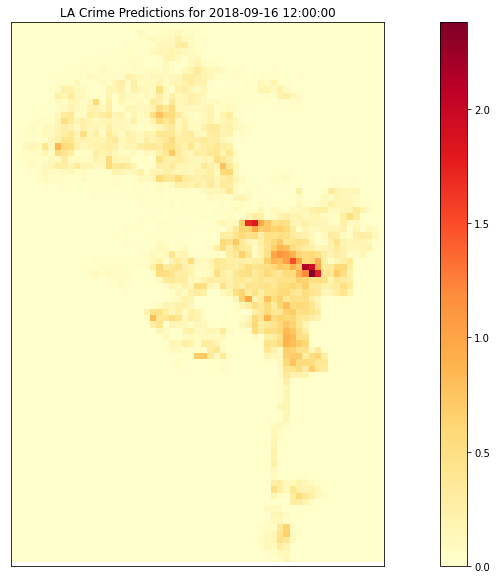

In [22]:
fig, ax = plt.subplots(figsize=(20,10))
ax.add_patch(descartes.PolygonPatch(geo_proj, fc="none"))
ax.set_aspect(1)

off = 1000
factor = 1


pred = trainer.prediction_from_background(model)
mappable = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="YlOrRd", rasterized=True)
fig.colorbar(mappable, ax=ax)
ax.set_title("LA Crime Predictions for " + str(this_date))
None
plt.xlim([min(xcoords_proj) - off, max(xcoords_proj) + off])
plt.ylim([min(ycoords_proj) - off, max(ycoords_proj) + off])
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
#how do we go from xcoords to the grid index? 

In [67]:
pred.index[pred.intensity_matrix != 0]

AttributeError: 'GridPredictionArray' object has no attribute 'index'

In [71]:
ycoords_proj[72]

4033368.3096225876

In [83]:
x_index = 72
y_index = 72
grid_x, grid_y = grid_proj.grid_coord(xcoords_proj[x_index], ycoords_proj[y_index])

pred.intensity_matrix[grid_y][grid_x]

0.0027624309392265192

/Users/annieulichney/opt/anaconda3/lib/python3.8/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]
/Users/annieulichney/opt/anaconda3/lib/python3.8/site-packages/descartes/patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +


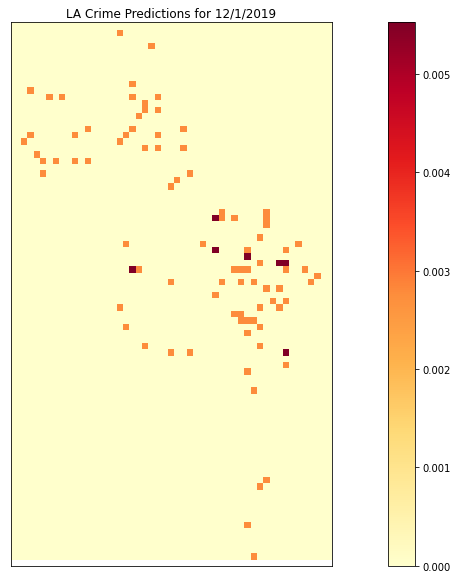

In [54]:
fig, ax = plt.subplots(figsize=(20,10))
ax.add_patch(descartes.PolygonPatch(geo_proj, fc="none"))
ax.set_aspect(1)

pred = trainer.prediction_from_background(model)
mappable = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="YlOrRd", rasterized=True)
fig.colorbar(mappable, ax=ax)
ax.set_title("LA Crime Predictions for 12/1/2019")
None
plt.xlim([min(xcoords_proj) - off, max(xcoords_proj) + off])
plt.ylim([min(ycoords_proj) - off, max(ycoords_proj) + off])
plt.xticks([])
plt.yticks([])
plt.show()

In [150]:
import sepp.kernels
import sepp.sepp_full
import numpy as np
import scipy.stats
from datetime import datetime

In [151]:
tk_time_prov = sepp.kernels.FixedBandwidthKernelProvider(1)
tk_space_prov = sepp.kernels.FixedBandwidthKernelProvider(20, cutoff=750)
back_ker_prov = sepp.kernels.FixedBandwidthKernelProvider(100)
opt_fac = sepp.sepp_full.Optimiser1Factory(back_ker_prov, tk_time_prov, tk_space_prov)
trainer = sepp.sepp_full.Trainer1(opt_fac)
trainer.data = points_proj
model = trainer.train(datetime(2019,12,1), iterations=5)
model

KeyboardInterrupt: 

In [ ]:
def compute_plot_kde(ker, size):
    x = np.linspace(-size, size, 151)
    y = x
    xcs, ycs = np.meshgrid(x, y)
    z = ker([xcs.flatten(), ycs.flatten()])
    z = z.reshape(xcs.shape)
    return x, y, z

def plot_kde(ax, ker, size, postprocess=None):
    x, y, z = compute_plot_kde(ker, size)
    if postprocess is not None:
        z = postprocess(z)
    return ax.pcolormesh(x,y,z, cmap="Greys", rasterized=True)

def backup_limits(ax):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    return xmin, xmax, ymin, ymax

def set_limits(ax, xmin, xmax, ymin, ymax):
    ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
    
def plot(model, space_size=35, time_size=100, space_floor=None):
    fig, axes = plt.subplots(ncols=3, figsize=(16,5))

    ax = axes[0]
    ax.add_patch(descartes.PolygonPatch(geo, fc="none"))
    ax.set_aspect(1)
    bpred = open_cp.predictors.grid_prediction_from_kernel(model.background_kernel, grid.region(), grid.xsize)
    #bpred = open_cp.predictors.GridPredictionArray(grid.xsize, grid.ysize, model.mu, grid.xoffset, grid.yoffset)
    m = ax.pcolor(*bpred.mesh_data(), bpred.intensity_matrix, cmap="Greys", rasterized=True)
    cb = fig.colorbar(m, ax=ax)

    ax = axes[1]
    x = np.linspace(0, time_size, 200)
    y = model.theta * model.trigger_time_kernel(x)
    ax.plot(x, y, color="black")
    ax.set(xlabel="Days", ylabel="Trigger risk")
    y = np.max(y)
    for t in range(0, time_size+1):
        ax.plot([t,t],[0,y], color="grey", linewidth=0.5, linestyle="--", zorder=-10)

    pp = None
    if space_floor is not None:
        pp = lambda z : np.log(space_floor + z)
    m = plot_kde(axes[2], model.trigger_space_kernel, space_size, pp)
    plt.colorbar(m, ax=axes[2])
        
    fig.tight_layout()
    return fig

def plot_scatter_triggers(backgrounds, trigger_deltas):
    fig, axes = plt.subplots(ncols=3, figsize=(16,5))

    def add_kde(ax, pts):
        xmin, xmax, ymin, ymax = backup_limits(ax)
        x = np.linspace(xmin, xmax, 151)
        y = np.linspace(ymin, ymax, 151)
        xcs, ycs = np.meshgrid(x, y)
        ker = scipy.stats.kde.gaussian_kde(pts)
        z = ker([xcs.flatten(), ycs.flatten()])
        z = z.reshape(xcs.shape)
        z = np.log(np.exp(-15)+z)
        m = ax.pcolorfast(x,y,z, cmap="Greys", rasterized=True, alpha=0.7, zorder=-10)

    ax = axes[0]
    pts = trigger_deltas[1:]
    ax.scatter(*pts, marker="x", color="black", linewidth=1)
    add_kde(ax, pts)
    ax.set_title("Space trigger points")

    ax = axes[1]
    pts = trigger_deltas[[0,1]]
    ax.scatter(*pts, marker="x", color="black", linewidth=1)
    add_kde(ax, pts)
    ax.set(xlabel="days", ylabel="x coord")#, xlim=[0,200])

    ax = axes[2]
    pts = trigger_deltas[[0,2]]
    ax.scatter(*pts, marker="x", color="black", linewidth=1)
    add_kde(ax, pts)
    ax.set(xlabel="days", ylabel="y coord")

    fig.tight_layout()
    return fig

def scatter_triggers(trainer, model, predict_time):
    backgrounds, trigger_deltas = trainer.sample_to_points(model, predict_time)
    return plot_scatter_triggers(backgrounds, trigger_deltas), backgrounds, trigger_deltas

In [ ]:
fig = plot(model, space_size=750, time_size=20, space_floor=np.exp(-20))

In [ ]:
fig, *_ = scatter_triggers(trainer, model, datetime.datetime(2017,1,1))